In [76]:
import os
import re
import collections
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import scipy
import seaborn as sns
import gzip
import glob
import datetime as dt
import gc
import sys
import tqdm as tq
from tqdm import tqdm
import time
import pickle
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, LSTM, GRU, Activation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow_probability as tfp
tfd = tfp.distributions
jpn_fonts=list(np.sort([ttf for ttf in fm.findSystemFonts() if 'ipaexg' in ttf or 'msgothic' in ttf or 'japan' in ttf or 'ipafont' in ttf]))
jpn_font=jpn_fonts[0]
prop = fm.FontProperties(fname=jpn_font)
print(jpn_font)
sns.set()

C:\Windows\Fonts\msgothic.ttc


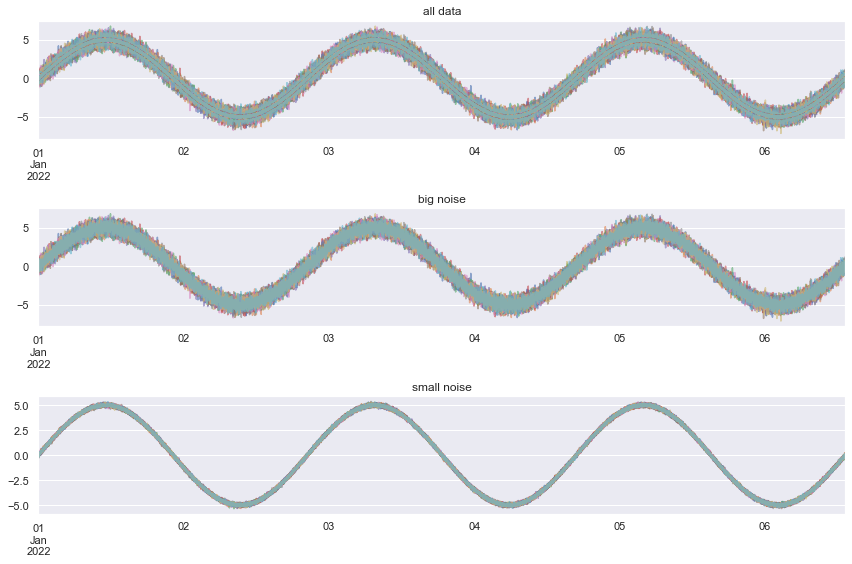

In [2]:
# 時系列データ長
input_data_length = 8000

# sin波＋Noise 1
big_noise_sin = np.array([ np.sin( np.linspace(0, np.pi*6, input_data_length) )\
                          * 5 + np.random.randn(input_data_length) * 0.5 for _ in range(20) ])
# sin波＋Noise 2
small_noise_sin = np.array([ np.sin( np.linspace(0, np.pi*6, input_data_length) )\
                            * 5 + np.random.randn(input_data_length) * 0.1 for _ in range(20) ])

# カラム名リスト
cols=['noise_sin_'+i for i in np.char.zfill(np.linspace(0,big_noise_sin.shape[0]-1
                                                        ,big_noise_sin.shape[0]).astype(int).astype(str)
                                            , 2)]
# df化
big_noise_sin_df=pd.DataFrame(big_noise_sin.T, columns=cols)

# カラム名リスト
cols=['noise_sin_'+i for i in np.char.zfill(np.linspace(0+big_noise_sin.shape[0]
                                                        ,small_noise_sin.shape[0]-1+big_noise_sin.shape[0]
                                                        ,small_noise_sin.shape[0]).astype(int).astype(str)
                                            , 2)]
# df化
small_noise_sin_df=pd.DataFrame(small_noise_sin.T, columns=cols)

# データ結合
data = pd.concat([big_noise_sin_df, small_noise_sin_df], axis=1)
# date index追加
data.index=pd.date_range(start='2022-1-1', periods=len(data), freq='min')

# データを可視化
fig = plt.figure(figsize = (12,8))
ax = fig.add_subplot(3,1,1)
data.plot(ax = ax, alpha=0.6, legend=False)
ax.set_title('all data')
ax = fig.add_subplot(3,1,2)
data.iloc[:,:20].plot(ax = ax, alpha=0.6, legend=False)
ax.set_title('big noise')
ax = fig.add_subplot(3,1,3)
data.iloc[:,20:].plot(ax = ax, alpha=0.6, legend=False)
ax.set_title('small noise')
plt.tight_layout()
plt.show()

In [95]:
data

,noise_sin_00,noise_sin_01,noise_sin_02,noise_sin_03,noise_sin_04,noise_sin_05,noise_sin_06,noise_sin_07,noise_sin_08,noise_sin_09,...,noise_sin_30,noise_sin_31,noise_sin_32,noise_sin_33,noise_sin_34,noise_sin_35,noise_sin_36,noise_sin_37,noise_sin_38,noise_sin_39
2022-01-01 00:00:00,-0.406439,-0.426061,-0.061569,0.110136,0.234339,-0.506794,0.303142,1.450801,0.093200,-0.201723,...,0.003610,0.075233,0.048255,0.018505,0.080774,0.085397,-0.040123,-0.055758,-0.028751,-0.223431
2022-01-01 00:01:00,-0.242199,-0.361203,-0.560552,-0.606311,-0.221134,-0.590252,-0.321849,0.292731,-0.273880,0.642519,...,-0.083135,0.114388,0.145730,-0.036136,0.226925,-0.002004,0.095891,-0.011450,-0.059237,0.075047
2022-01-01 00:02:00,0.299553,0.082647,0.871398,0.861259,-0.092794,-0.061408,-0.461005,-0.435363,0.230438,-0.116796,...,0.086293,-0.023832,-0.084821,0.065221,0.232242,-0.026412,0.032570,0.087503,0.157760,0.032392
2022-01-01 00:03:00,0.166677,-0.468831,-0.400433,-0.721651,-0.265918,1.018668,-0.417919,0.935099,0.587452,0.379997,...,-0.025384,0.206893,0.138846,-0.094282,0.228160,-0.028138,0.151079,-0.156039,-0.167485,-0.166445
2022-01-01 00:04:00,0.011846,-0.508914,-0.132796,-0.125563,-0.797379,-0.094663,-0.459933,0.367928,-0.093319,0.154389,...,-0.201453,-0.019641,-0.131458,0.051631,0.024863,0.156730,0.135544,-0.299004,0.091133,0.097281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-06 13:15:00,-0.244969,-0.161010,-0.510744,0.736483,0.151881,0.172053,0.120933,0.711186,0.149945,-0.091952,...,-0.017878,-0.036266,-0.013759,0.092669,-0.162512,-0.058281,-0.214440,-0.003960,-0.015884,-0.221186
2022-01-06 13:16:00,0.779124,0.317879,0.198039,0.034853,-0.102784,-0.022564,-0.222333,0.898312,-0.070739,0.581218,...,-0.127992,-0.026088,-0.035245,-0.000210,-0.026077,0.052231,-0.146533,0.067757,0.023659,0.089396
2022-01-06 13:17:00,0.241123,-0.367371,-0.212737,0.241856,-0.450022,0.868952,-0.154732,0.401785,0.222979,0.145526,...,-0.026101,0.073207,0.015924,0.075619,0.147486,-0.020867,-0.102617,0.012395,-0.002686,0.019928
2022-01-06 13:18:00,0.555359,-0.722337,-0.854264,-0.058713,0.001502,-0.332683,-0.721963,0.431295,-0.525435,-0.337330,...,0.058470,-0.070240,0.164980,0.076835,-0.075479,-0.017399,-0.225863,0.123032,-0.066705,0.064984


In [3]:
# モデル学習/適用のためにデータを加工
def generate_data(data, length_per_unit, dimension, obs_col, pred_l=1):
    '''
    data:df
    length_per_unit:説明変数に使用する過去の時系列の長さ（N秒前、N日前など）
    dimension:説明変数の次元
    obs_col:目的変数名
    pred_l:予測する時系列の長さ（N秒先、N日先など）
    '''
    # 目的変数のIndex番号
    obs_ind=np.where(data.columns.to_numpy()==obs_col)[0][0]
    # DataFrame→array変換
    data_array = data.to_numpy()
    # 時系列データを入れる箱
    sequences = []
    # 正解データを入れる箱
    target = []
    
    # length_per_unitごとに時系列データと正解データをセットで追加していく
    for i in range(0, data_array.shape[0] - length_per_unit - pred_l):
        sequences.append(data_array[i:i + length_per_unit])
        target.append(data_array[(i + length_per_unit):(i + length_per_unit + pred_l)])

    # 時系列データを成形
    X = np.array(sequences).reshape(len(sequences), length_per_unit, dimension)
    # 正解データを成形
    Y = np.array(target).reshape(len(sequences), pred_l, dimension)
    Y = Y[:,:,obs_ind].reshape(Y.shape[0],Y.shape[1],1)

    return X,Y

In [9]:
# データ前処理
length=60 # 60-1分前のデータを説明変数にする
col = 'noise_sin_33'# 目的変数名
X_data, y_data = generate_data(data, length, data.shape[1], obs_col=col , pred_l=1)# 目的変数は1分後のデータ
X_train, y_train = X_data[:int(len(X_data)*0.7), :, :], y_data[:int(len(X_data)*0.7), :]# Train Data
X_valid, y_valid = X_data[int(len(X_data)*0.7):int(len(X_data)*0.8), :, :], y_data[int(len(X_data)*0.7):int(len(X_data)*0.8), :]# Valid Data
X_test, y_test = X_data[int(len(X_data)*0.8):, :, :], y_data[int(len(X_data)*0.8):, :]# Test Data
print('Train DataX{}'.format(X_train.shape), 'Valid DataX{}'.format(X_valid.shape), 'Test DataX{}'.format(X_test.shape))
print('Train DataY{}'.format(y_train.shape), 'Valid DataY{}'.format(y_valid.shape), 'Test DataY{}'.format(y_test.shape))

Train DataX(5557, 60, 40) Valid DataX(794, 60, 40) Test DataX(1588, 60, 40)
Train DataY(5557, 1, 1) Valid DataY(794, 1, 1) Test DataY(1588, 1, 1)


In [14]:
%%time
# LSTM, GRUネットワーク組み立て(昔別のデータの時に書いたコード流用)
#Input(shape=((列数（シーケンスの長さ）,次元（データの数）)))
inputs = tf.keras.layers.Input(shape=((X_train.shape[1],X_train.shape[2])))
num_out1=[32]
num_out2=16
num_out3=8
activation1='relu'
optimizer='adam'

# 多層GRUネットワーク
for i in range(0, len(num_out1)):
    if i == 0:
        embed = tf.keras.layers.GRU(num_out1[i], return_sequences=True)(inputs)
    else:
        embed = tf.keras.layers.GRU(num_out1[i], return_sequences=True)(embed)

# 最後LSTM持ってくる
embed = tf.keras.layers.LSTM(num_out2, return_sequences=False)(embed)

# 活性化関数はrelu
hiddened = tf.keras.layers.Dense(num_out3, activation=activation1)(embed)
# 出力層
pred_out = tf.keras.layers.Dense(2)(hiddened)# 出力の次元を2にする（正規分布のμとσの2つ）
pred_out = tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t[..., :1]
                                                              , scale=1e-5 + tf.math.softplus(0.001 * t[..., 1:])))(pred_out)

model = tf.keras.models.Model(inputs=inputs, outputs=pred_out)
model.summary()

# コンパイル
negloglik = lambda y, rv_y: -rv_y.log_prob(y)
model.compile(optimizer=optimizer, loss=negloglik)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 60, 40)]          0         
_________________________________________________________________
gru_2 (GRU)                  (None, 60, 32)            7104      
_________________________________________________________________
lstm_2 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 18        
_________________________________________________________________
distribution_lambda_2 (Distr multiple                  0         
Total params: 10,394
Trainable params: 10,394
Non-trainable params: 0
_______________________________________________________

In [15]:
%%time
# 学習
batch_size=128
epochs=500
model_path='prob_dist_predict_model.hdf5'
call_backs=[tf.keras.callbacks.EarlyStopping(patience=10), tf.keras.callbacks.ModelCheckpoint(model_path, save_best_only=True)]
log_dir = "logs/fit/" + dt.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
# 1分先の数値を目的変数とする
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs
                    , callbacks=[call_backs, tensorboard_callback]
                    , validation_data=(X_valid, y_valid), shuffle=False)

Epoch 1/500
Cause: could not parse the source code of <function <lambda> at 0x000001A156927C18>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x000001A156927C18>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
44/44 [==============================] - 4s 49ms/step - loss: 8.7533 - val_loss: 2.9082
Epoch 2/500
44/44 [==============================] - 1s 28ms/step - loss: 3.3364 - val_loss: 2.5277
Epoch 3/500
44/44 [==============================] - 1s 28ms/step - loss: 2.3322 - val_loss: 1.2410
Epoch 4/500
44/44 [==============================] - 1s 27ms/step - loss: 1.6721 - val_loss: 0.9109
Epoch 5/500
44/44 [==============================] - 1s 27ms/step - loss: 1.3064 - val_loss: 0.8296
Epoch 6/500
44/44 [==============================] - 1s 27ms/step - loss: 1.0999 - val_loss: 0.771

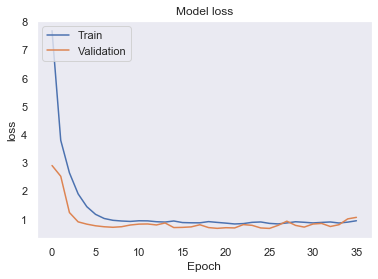

In [16]:
# Loss Plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.grid()
plt.legend(['Train', 'Validation'], loc='upper left')
#plt.ylim(-10,5)
plt.show()

In [17]:
model = tf.keras.models.load_model("prob_dist_predict_model.hdf5", compile=False)
model.compile(optimizer=optimizer, loss=negloglik)

In [18]:
# モデル適用で予測結果(平均と1/標準偏差)を出力
# モデル適用で予測結果(平均と1/標準偏差)を出力
results_tra = model(X_train)
results_val = model(X_valid)
results_tes = model(X_test)

In [100]:
print(results_tra.mean())
print(results_tra.stddev())

tf.Tensor(
[[0.5447341]
 [0.564435 ]
 [0.576095 ]
 ...
 [2.8608506]
 [2.821735 ]
 [2.833903 ]], shape=(5557, 1), dtype=float32)
tf.Tensor(
[[0.69287735]
 [0.6928656 ]
 [0.6928619 ]
 ...
 [0.6930328 ]
 [0.6930416 ]
 [0.6930426 ]], shape=(5557, 1), dtype=float32)


<tf.Tensor: shape=(5557, 1), dtype=float32, numpy=
array([[0.48007903],
       [0.48006275],
       [0.48005763],
       ...,
       [0.48029447],
       [0.48030668],
       [0.48030803]], dtype=float32)>

In [35]:
# 平均と標準偏差を出力
pred_tra, sigma_tra=results_tra.mean().numpy().reshape(-1), results_tra.stddev().numpy().reshape(-1)# 平均, 標準偏差
pred_val, sigma_val=results_val.mean().numpy().reshape(-1), results_val.stddev().numpy().reshape(-1)# 平均, 標準偏差
pred_tes, sigma_tes=results_tes.mean().numpy().reshape(-1), results_tes.stddev().numpy().reshape(-1)# 平均, 標準偏差
# 結合
pred_all=np.hstack((pred_tra,pred_val,pred_tes))# train, valid, testの結合
sigma_all=np.hstack((sigma_tra,sigma_val,sigma_tes))# train, valid, testの結合
# 平均±2σ
nsig = 2
pred_all_pls=pred_all+(nsig*sigma_all)
pred_all_mns=pred_all-(nsig*sigma_all)
print(pred_all)
print(sigma_all)
print(pred_all_pls)
print(pred_all_mns)

[0.5447341 0.564435  0.576095  ... 0.5863633 0.5740509 0.454729 ]
[0.69287735 0.6928656  0.6928619  ... 0.69303554 0.6930489  0.69306314]
[1.9304888 1.9501662 1.9618188 ... 1.9724344 1.9601487 1.8408552]
[-0.8410206  -0.8212962  -0.80962884 ... -0.7997078  -0.8120469
 -0.9313973 ]


In [36]:
y_all = np.vstack((y_train[:,0,:],y_valid[:,0,:],y_test[:,0,:]))
y_all

array([[ 6.70737363e-01],
       [ 7.46234575e-01],
       [ 7.23424305e-01],
       ...,
       [-2.09823093e-04],
       [ 7.56189044e-02],
       [ 7.68345506e-02]])

In [58]:
# X軸
date_times = data.index.to_numpy()[:len(y_all)]
# 異常値を差し込んでおく#2022-01-05 22:20:00 2022-01-05 22:29:00
y_all[7100:7110]=-2.0
# 閾値外に出る日時のIndex番号取得
anom_span = np.where(((y_all.reshape(-1)-pred_all_mns.reshape(-1))*(y_all.reshape(-1)-pred_all_pls.reshape(-1)))>=0)[0]

In [88]:
y_all.max()

5.254071039555197

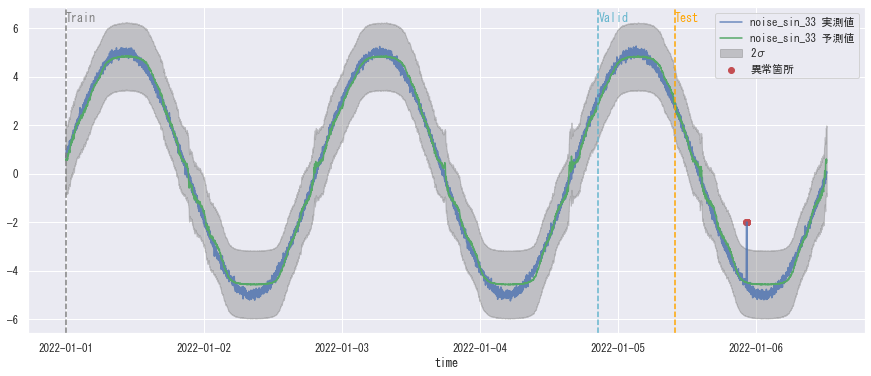

In [94]:
# 実測値, 予測値±2σを可視化
plt.figure(figsize=(15,6))
plt.rcParams['font.family'] = prop.get_name()
ax=plt.subplot(1,1,1)
ax.plot(date_times, y_all, label=col+' 実測値', color='b', alpha=0.8)
ax.set_xlabel('time')
ax.plot(date_times, pred_all, label=col+' 予測値', color='g', alpha=1.0)
ax.fill_between(date_times
                , pred_all_mns, pred_all_pls, label=str(nsig)+'σ', color="gray", alpha=0.4)
ax.axvline(x=date_times[0], ls='--', c='gray')
ax.text(date_times[0], pred_all_pls.max(), "Train", c='gray')
ax.axvline(x=date_times[int(len(X_data)*0.7)], ls='--', c='c')
ax.text(date_times[int(len(X_data)*0.7)], pred_all_pls.max(), "Valid", c='c')
ax.axvline(x=date_times[int(len(X_data)*0.8)], ls='--', c='orange')
ax.text(date_times[int(len(X_data)*0.8)], pred_all_pls.max(), "Test", c='orange')
ax.scatter(date_times[anom_span], y_all[anom_span], label='異常箇所', color='r', alpha=1.)
ax.legend(loc='upper right')
plt.show()